In [1]:
import mesa
import math
import numpy as np
from model import Evacuation
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm

In [2]:
sns.set_theme(style = "whitegrid", palette = "Pastel1")

In [3]:
#Evacuation(n=10, width=20, height=10, door_width = 4, seed=10, model_type = "BNE_mixed_SR", p_BNE = 100)

def batch_run(params, iters = 50):

    if __name__ == '__main__':
        results = mesa.batch_run(
            Evacuation,
            parameters=params,
            iterations=iters,
            max_steps=350,
            number_processes=8,
            data_collection_period=-1,
            display_progress=1
        )

    results_df = pd.DataFrame(results)
    ev_times = results_df.groupby("RunId").first().Step
    return ev_times

### Czas ewakuacji dla ustalonego otoczenia i liczby pieszych w zależności od algorytmu

#### box ploty

In [4]:
results_box_bne = batch_run({"n": 1000 , "width": 68, "height": 20, "door_width": 6, "seed": None, "model_type": "BNE_mixed_SR", "p_BNE": 100})

  0%|          | 0/50 [00:00<?, ?it/s]

In [5]:
results_box_rf = batch_run({"n": 1000 , "width": 68, "height": 20, "door_width": 6, "seed": None, "model_type": "BNE_mixed_RF", "p_BNE": 0})

  0%|          | 0/50 [00:00<?, ?it/s]

In [6]:
results_box_sr = batch_run({"n": 1000 , "width": 68, "height": 20, "door_width": 6, "seed": None, "model_type": "BNE_mixed_SR", "p_BNE": 0})

  0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
box_df = pd.DataFrame(
    {   "model_type": np.repeat(["BNE", "SR", "RF"], 50),
        "exit_time": np.concatenate((results_box_bne.values, results_box_sr.values, results_box_rf.values))
    })
box_df

,model_type,exit_time
0,BNE,105
1,BNE,99
2,BNE,106
3,BNE,103
4,BNE,350
...,...,...
145,RF,83
146,RF,118
147,RF,193
148,RF,156


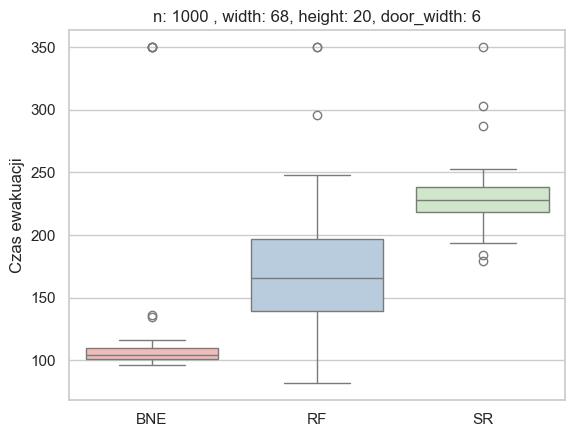

In [8]:
sns.boxplot( np.array([results_box_bne, results_box_rf, results_box_sr]).T)
plt.xticks(np.arange(3), ["BNE", "RF", "SR"])
plt.title("n: 1000 , width: 68, height: 20, door_width: 6")
plt.ylabel("Czas ewakuacji")
plt.show()

#### Przykładowe klatki z różnych metod

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mplc

def frames(method):
    model_type = method[0]
    p_bne = method[1]

    frames_nums = [0, 20, 40, 60, 80, 100]
    model = Evacuation(n=1000, width=68, height=20, door_width=6, seed=10, model_type=model_type, p_BNE=p_bne)

    # Create the full figure once
    fig, axs = plt.subplots(6, 1, figsize=(10, 30))  # 6 rows, 1 column, adjust size

    step_num = 0
    frame_idx = 0

    while model.running:
        agent_counts = np.zeros((model.grid.width, model.grid.height))
        for cell_content, (x, y) in model.grid.coord_iter():
            agent_count = len(cell_content)
            agent_counts[x][y] = agent_count

        if step_num in frames_nums and frame_idx < 6:
            print(step_num)
            ax = axs[frame_idx]
            sns.set_style('dark', {"axes.facecolor": "0.95"})
            sns.heatmap(
                agent_counts.T,
                cmap="mako_r",
                annot=True,
                cbar=False,
                norm=mplc.LogNorm(vmin=1, vmax=10),
                ax=ax
            )
            ax.invert_yaxis()
            ax.set_title(f"{model_type} step {step_num}")
            frame_idx += 1

        model.step()
        step_num += 1

    plt.tight_layout()
    plt.show()


In [ ]:
frames(("BNE_mixed_SR", 100))

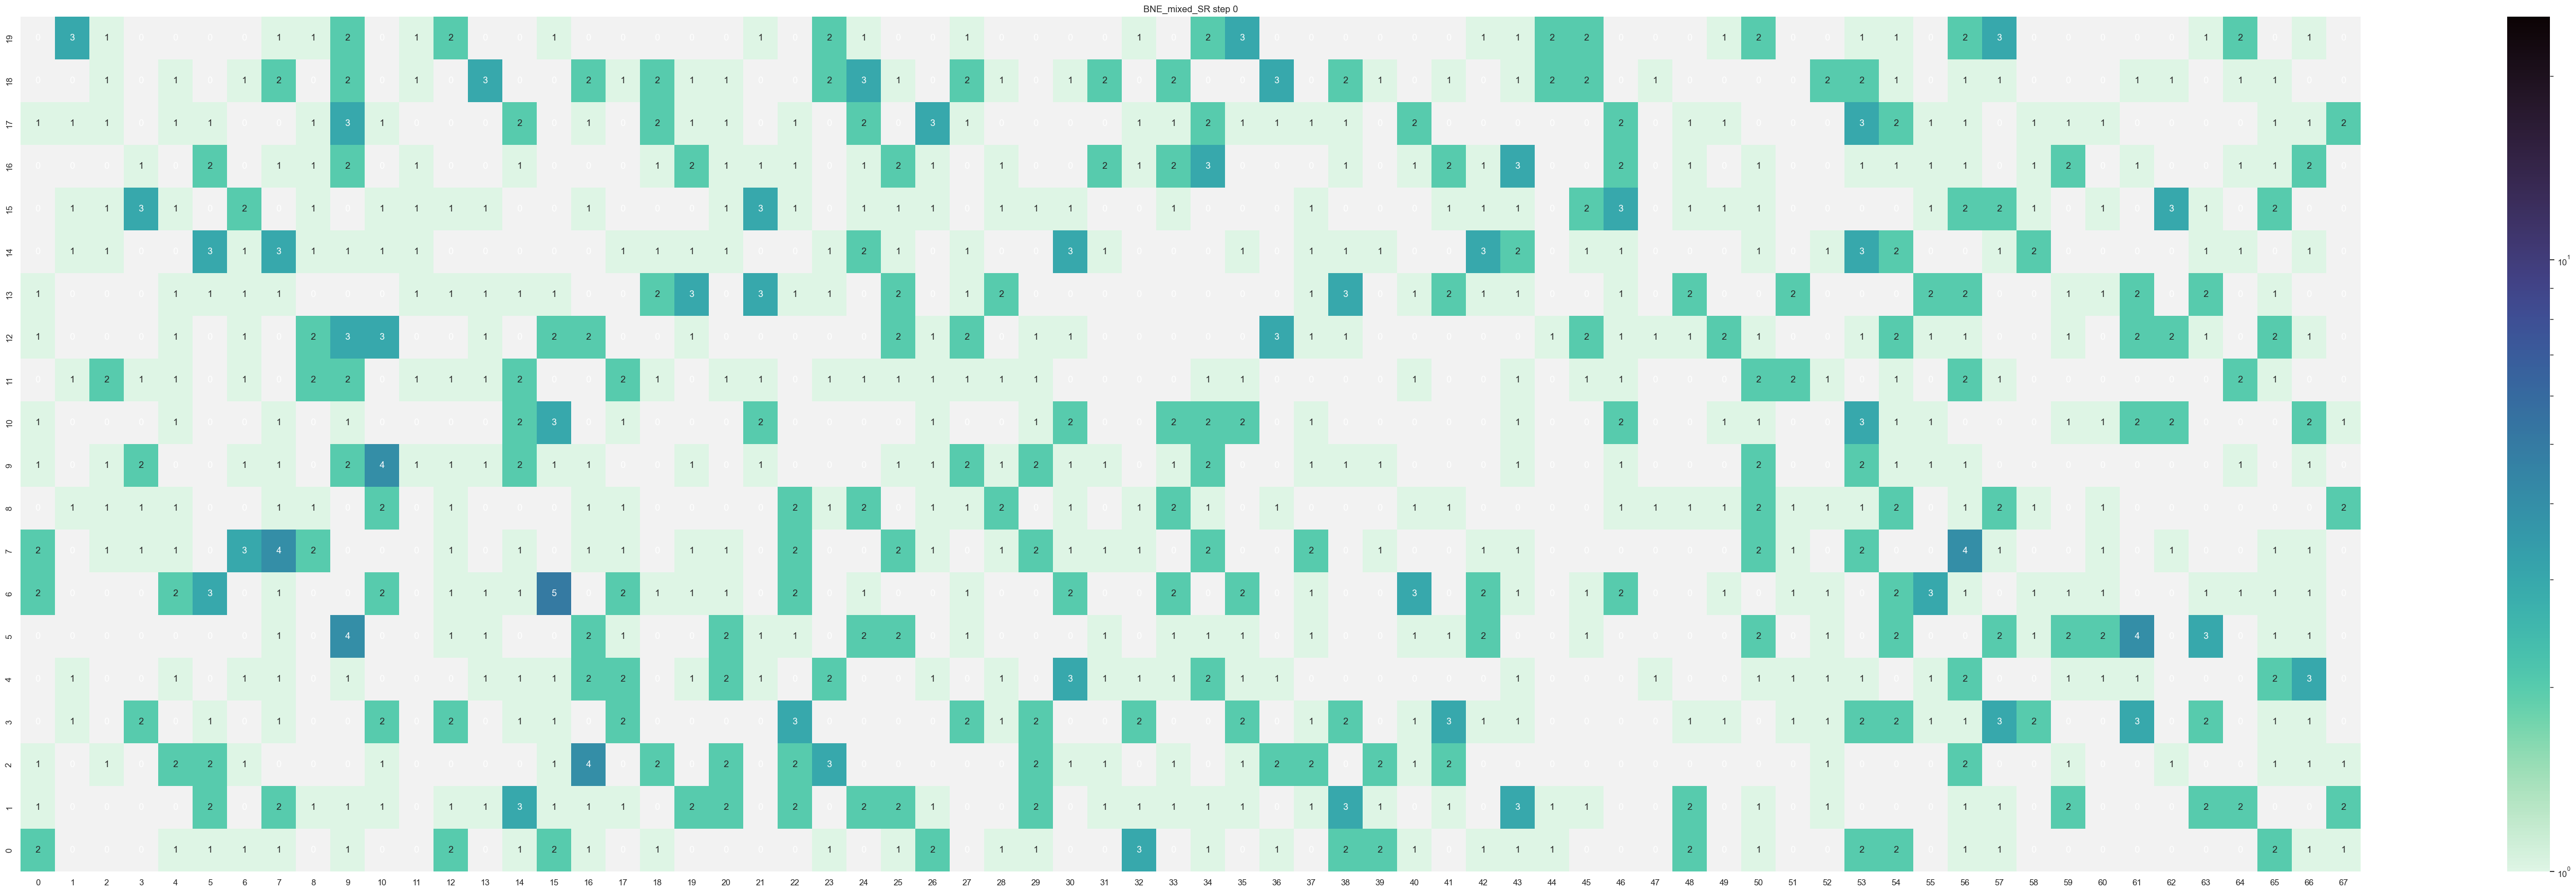

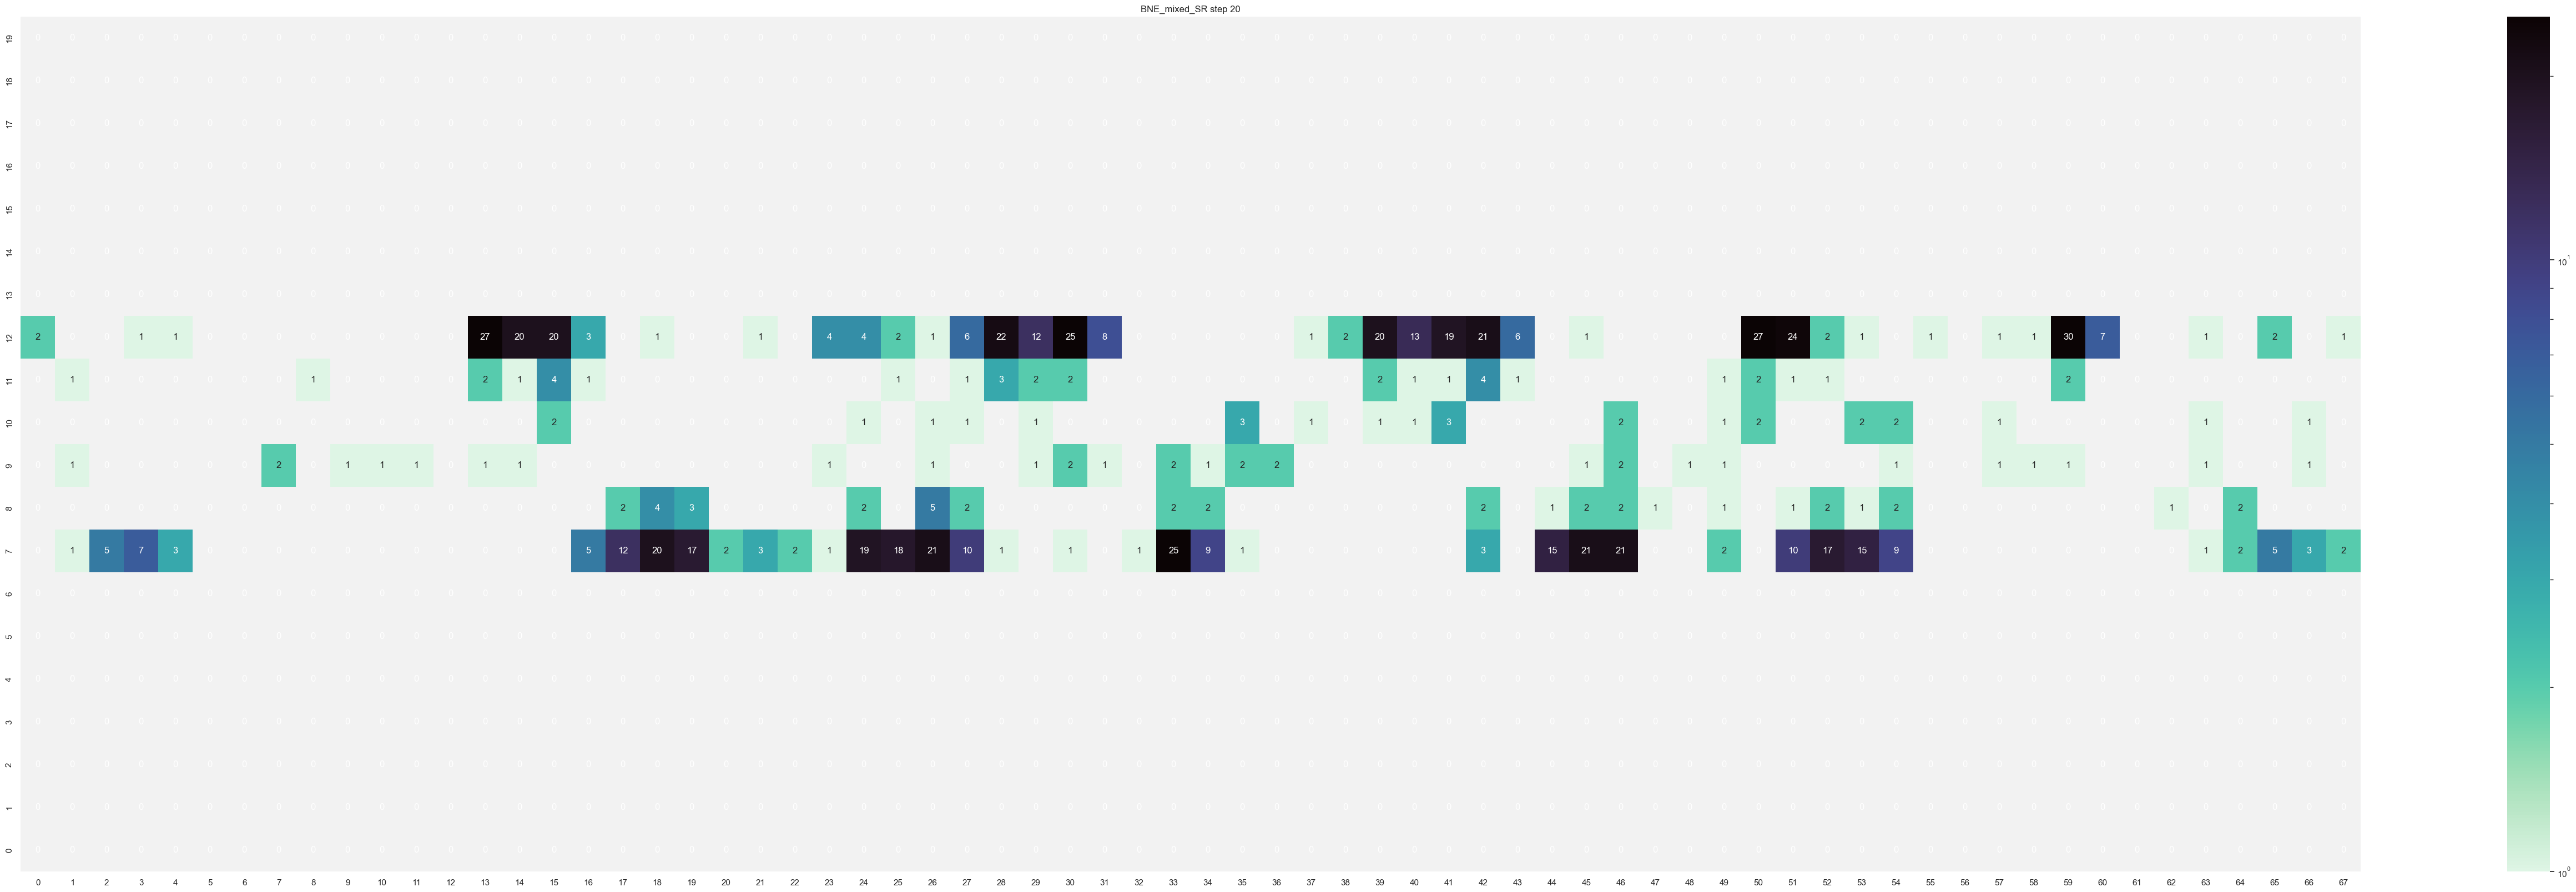

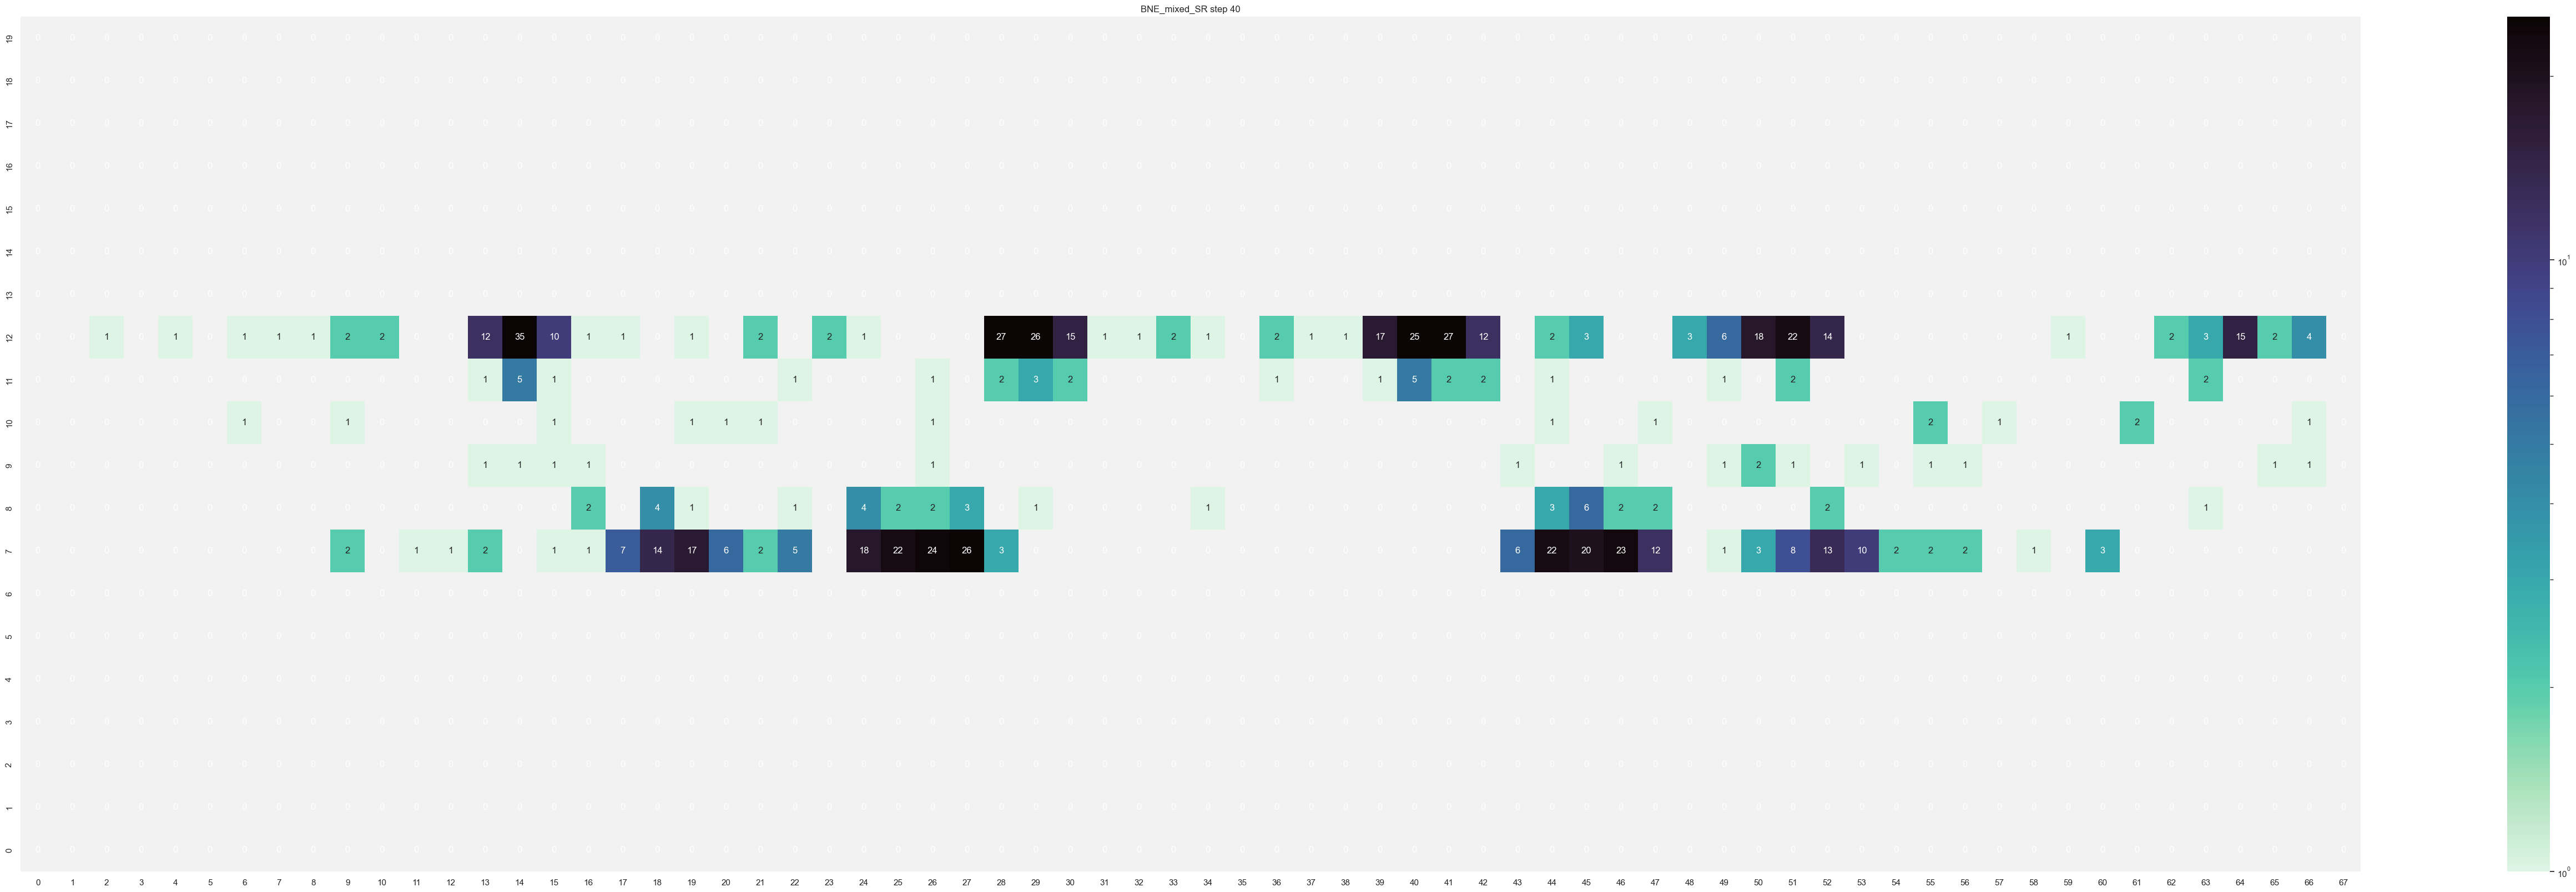

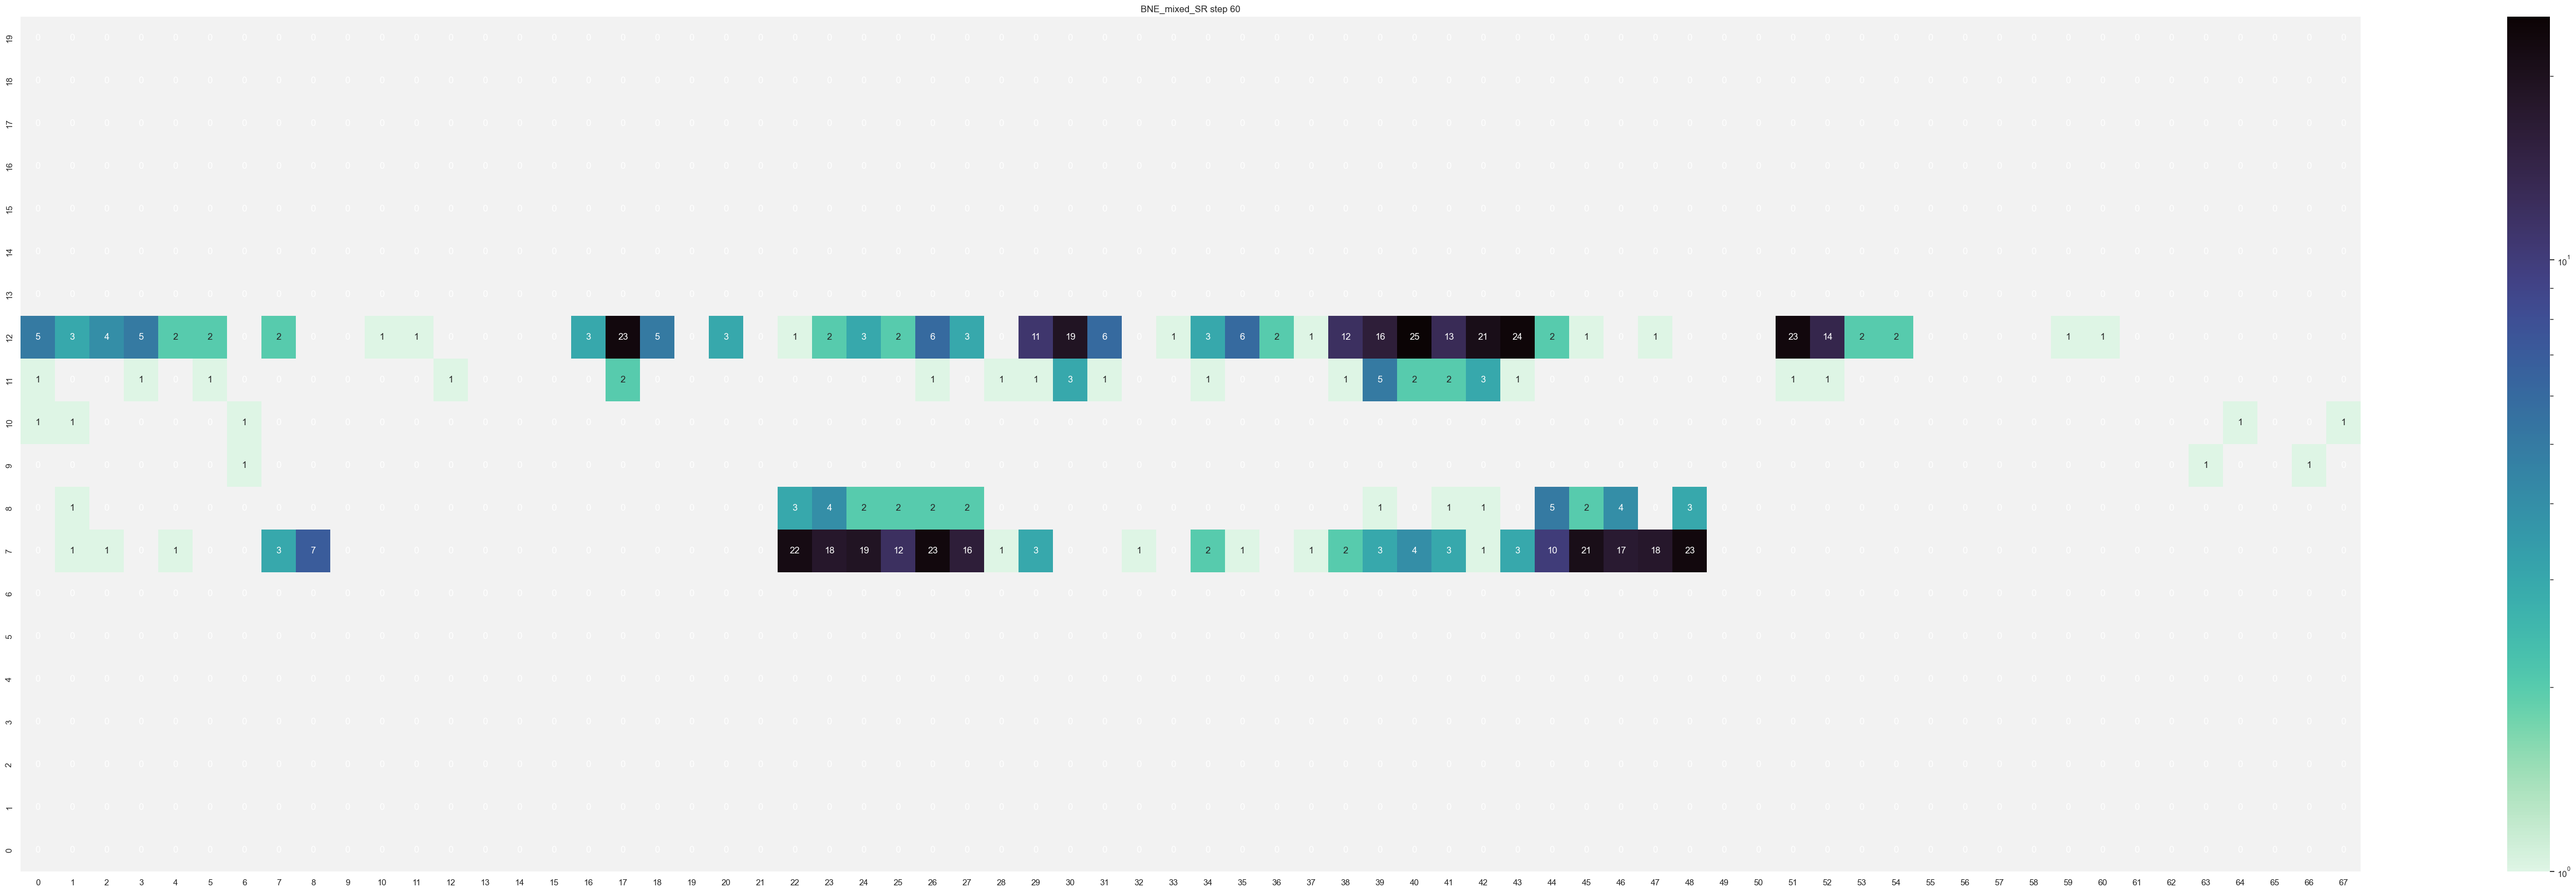

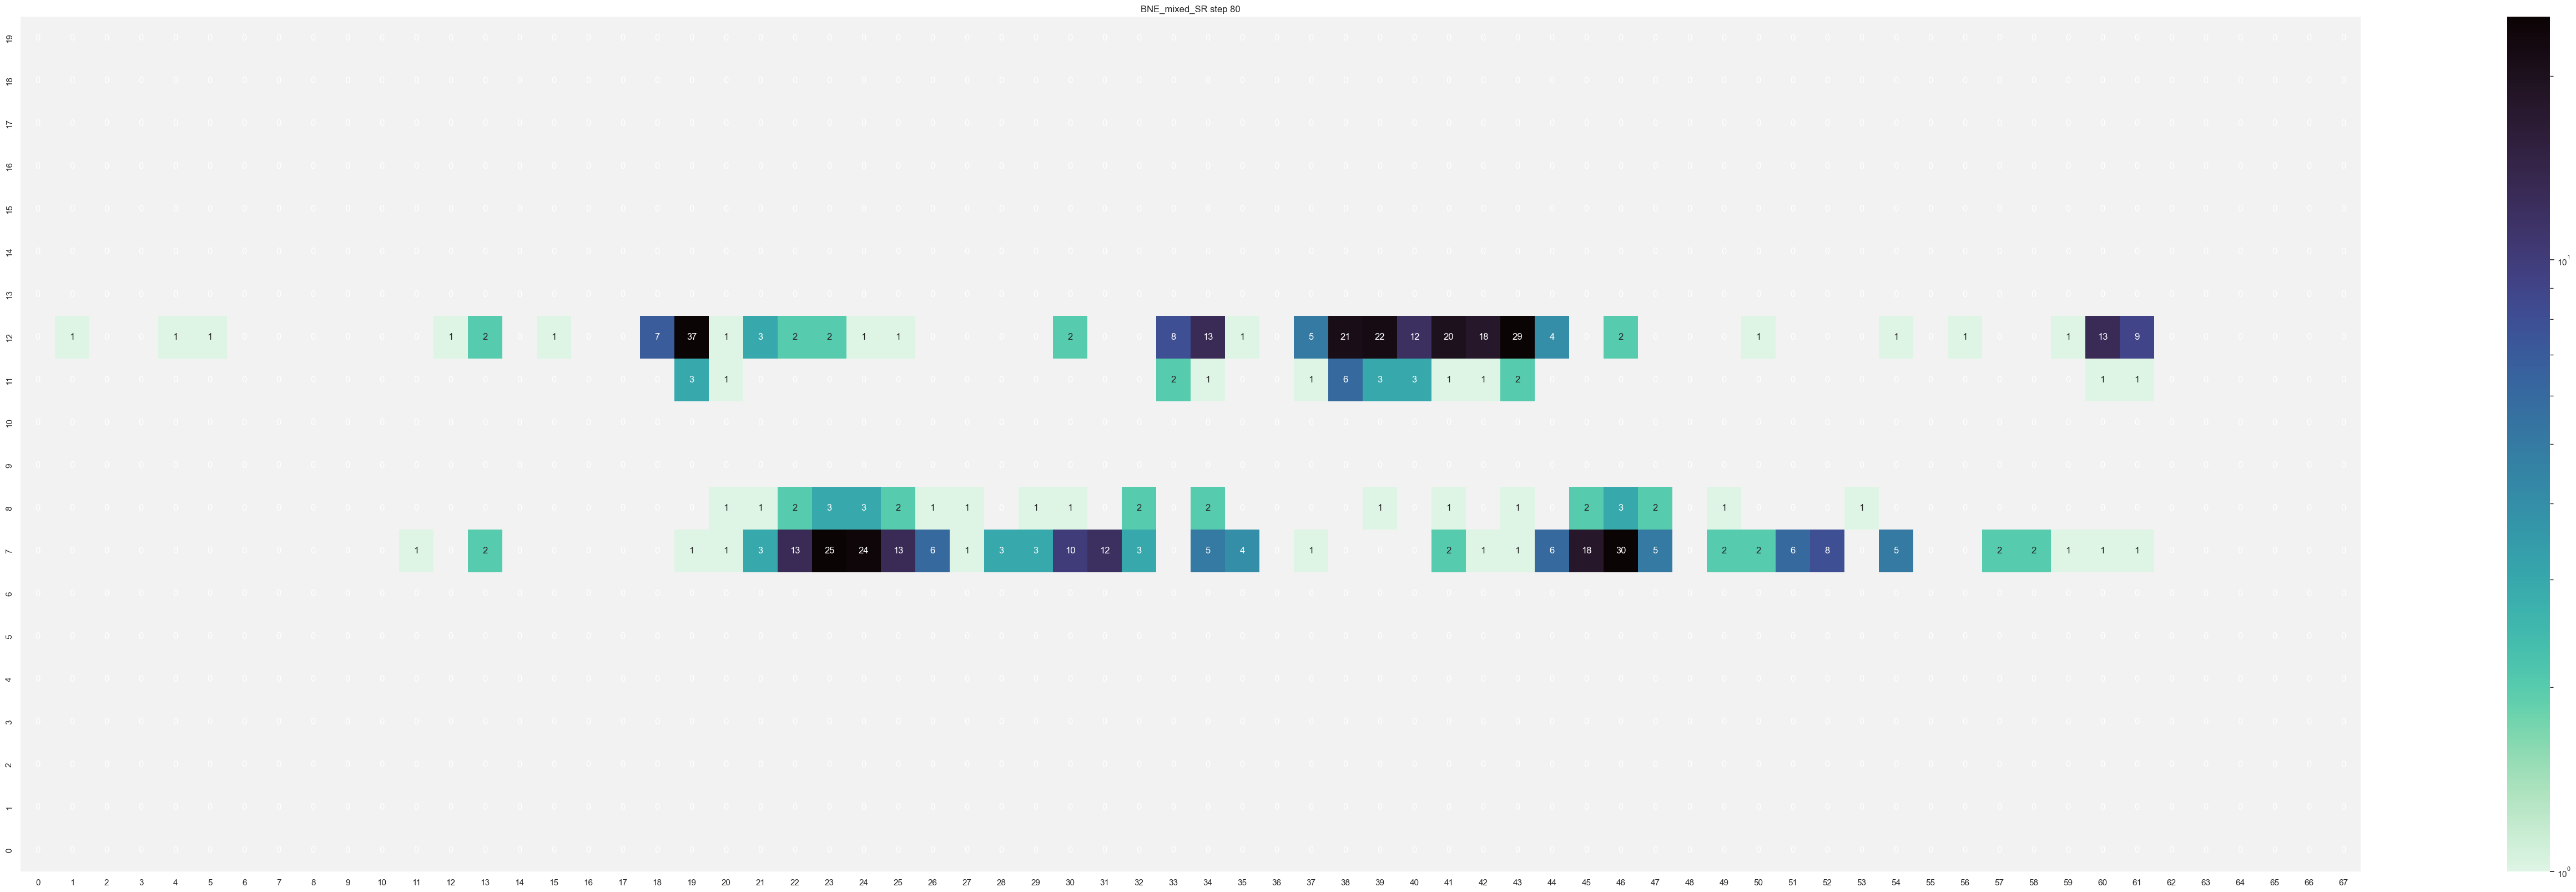

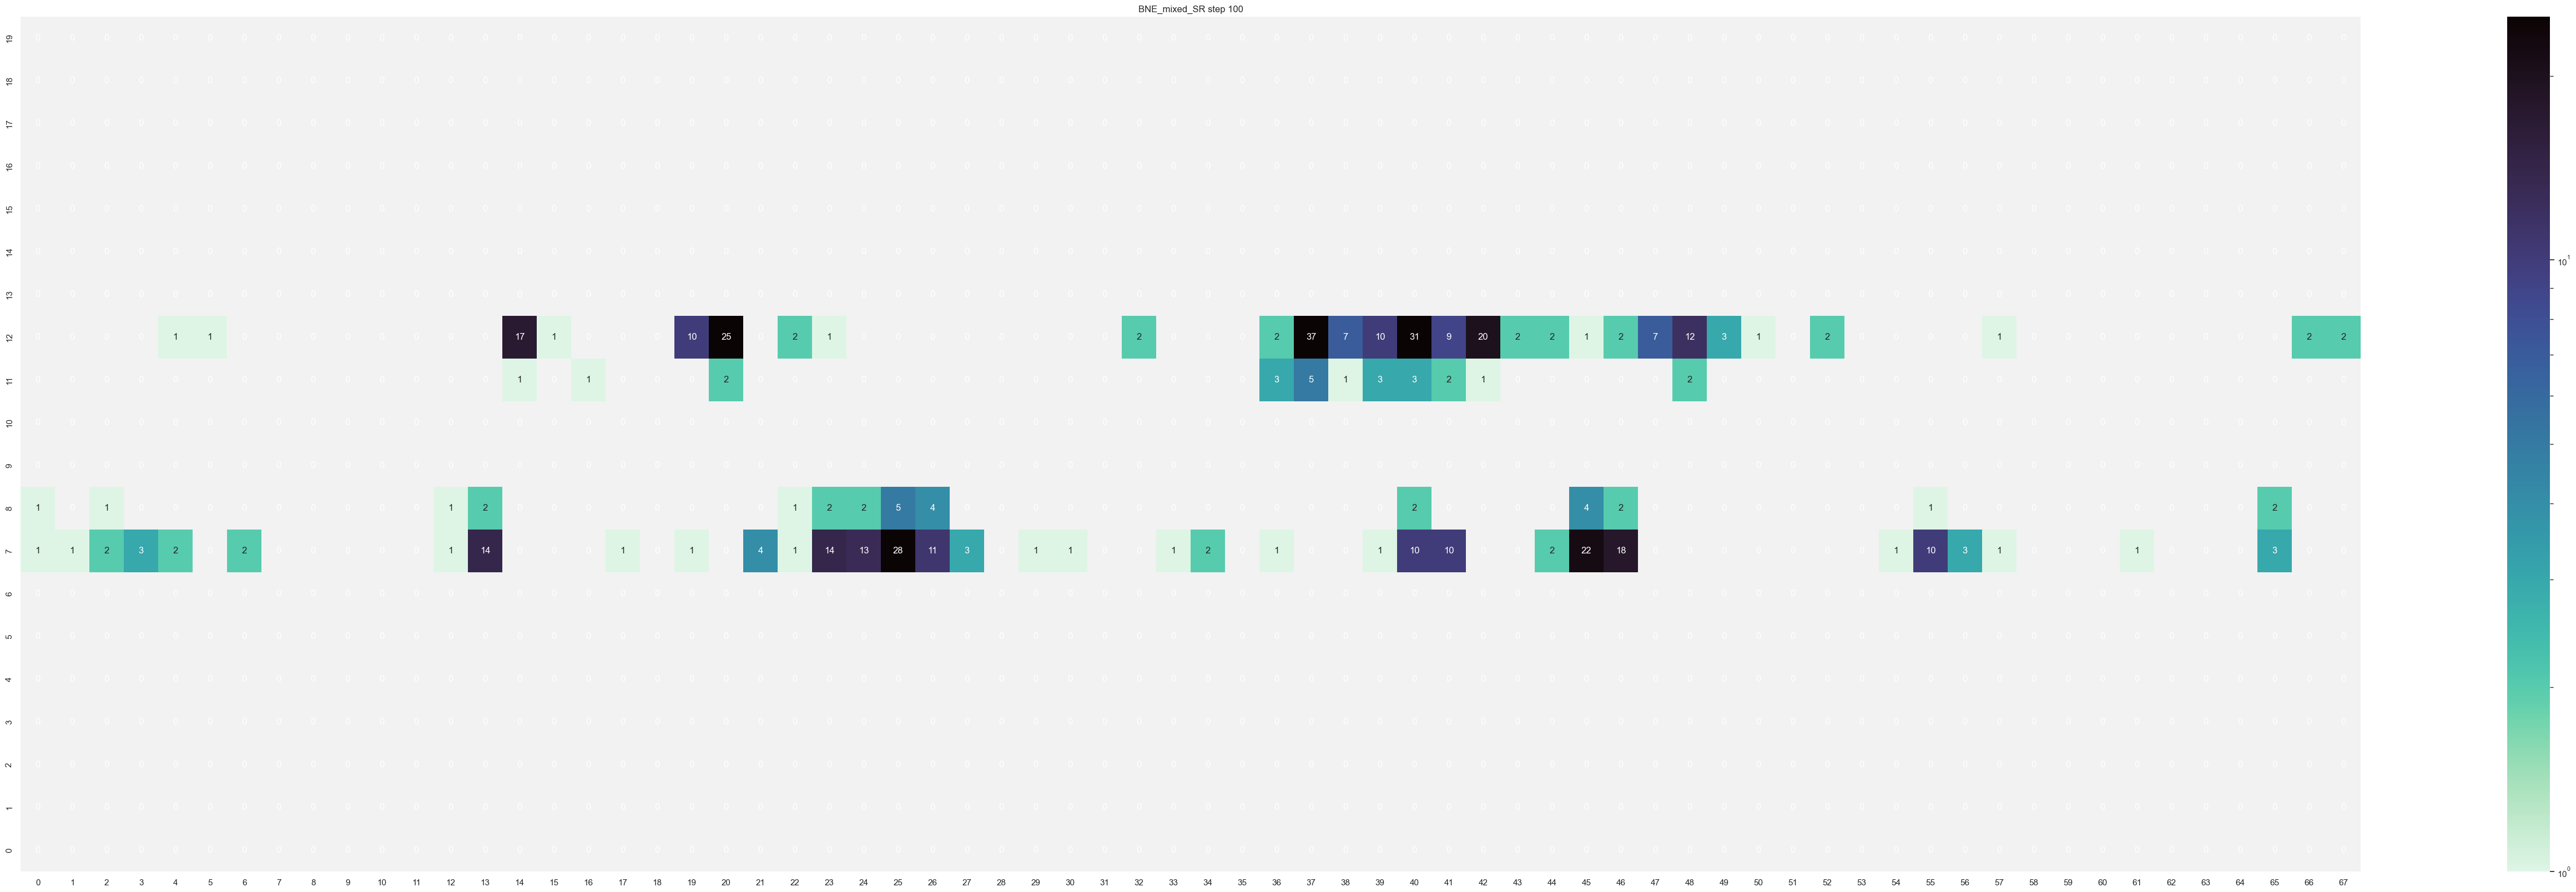

In [11]:
frames(("BNE_mixed_SR", 0))

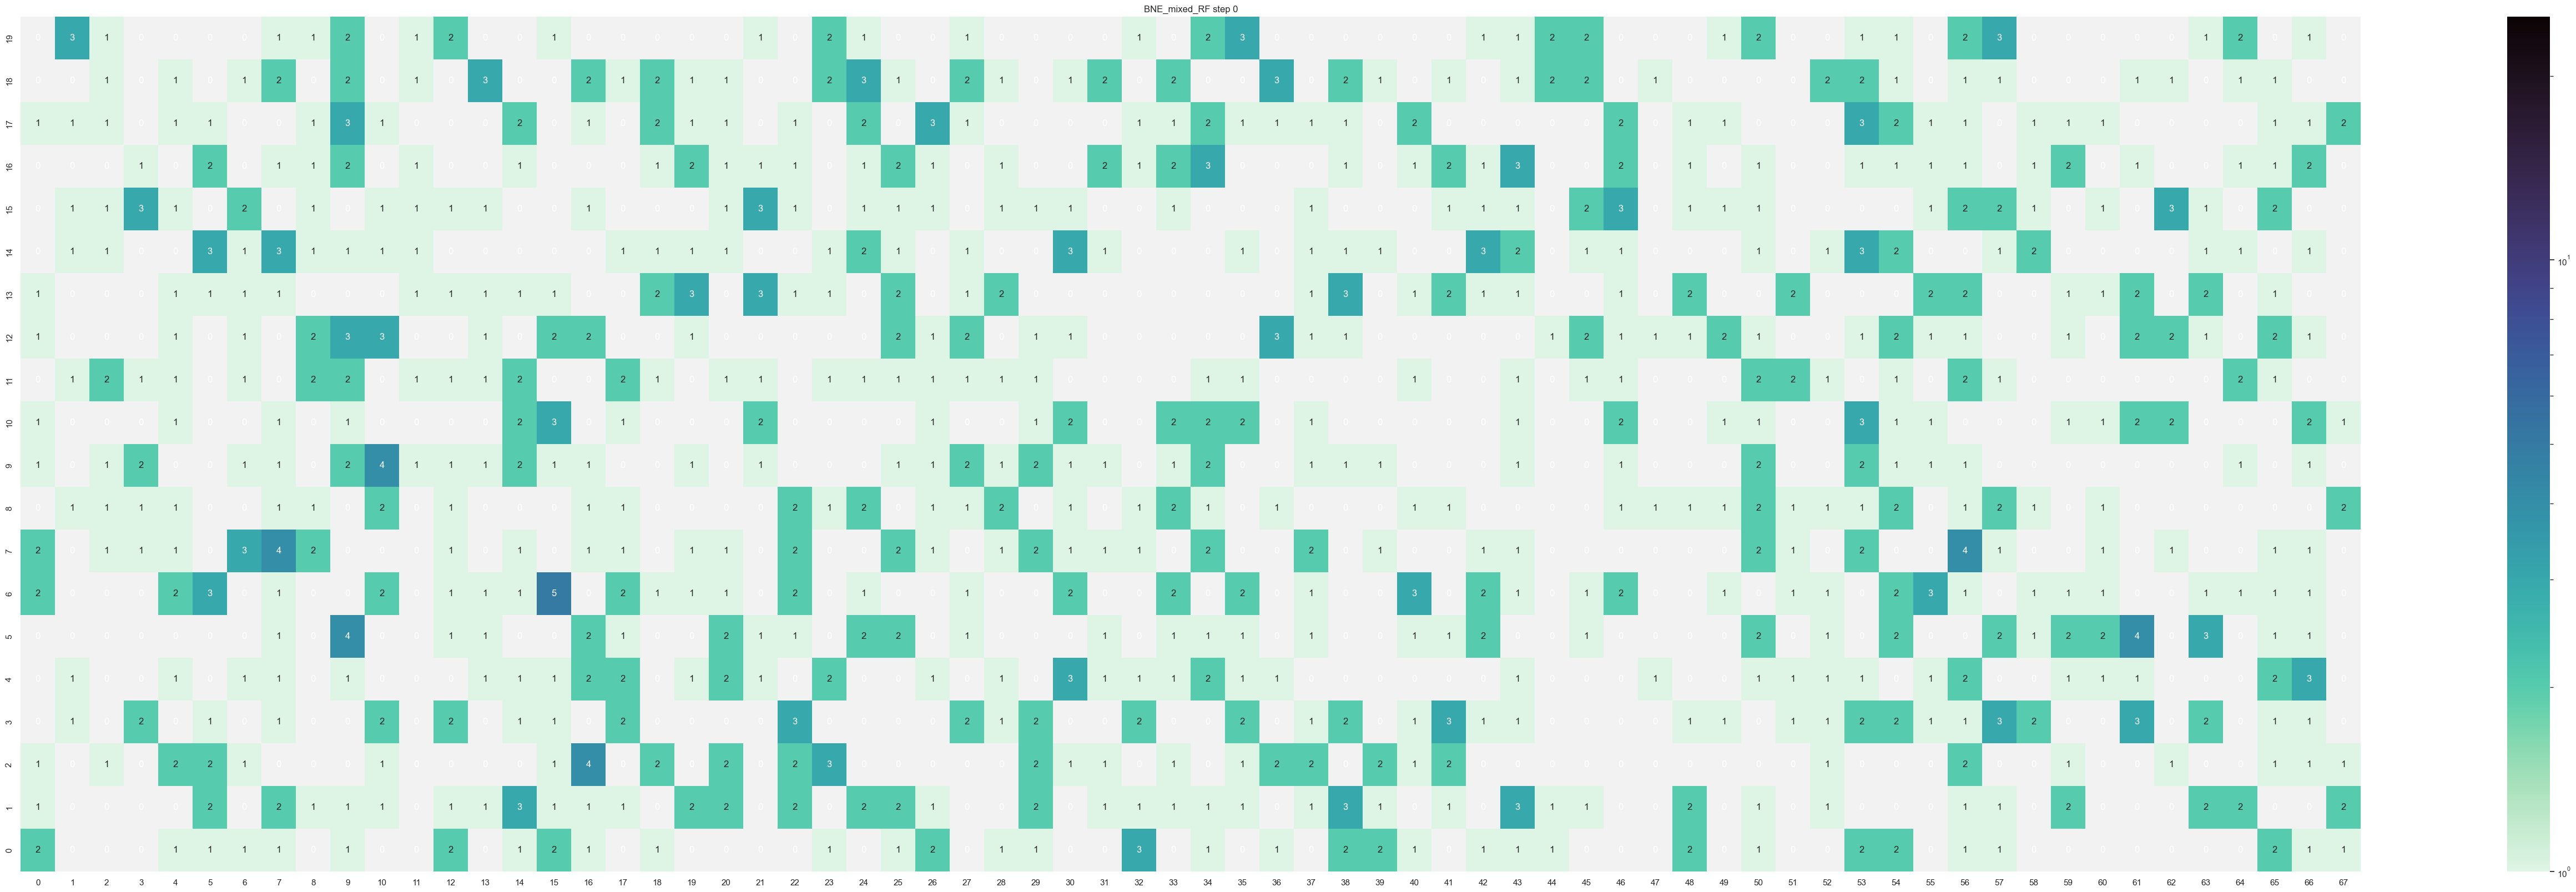

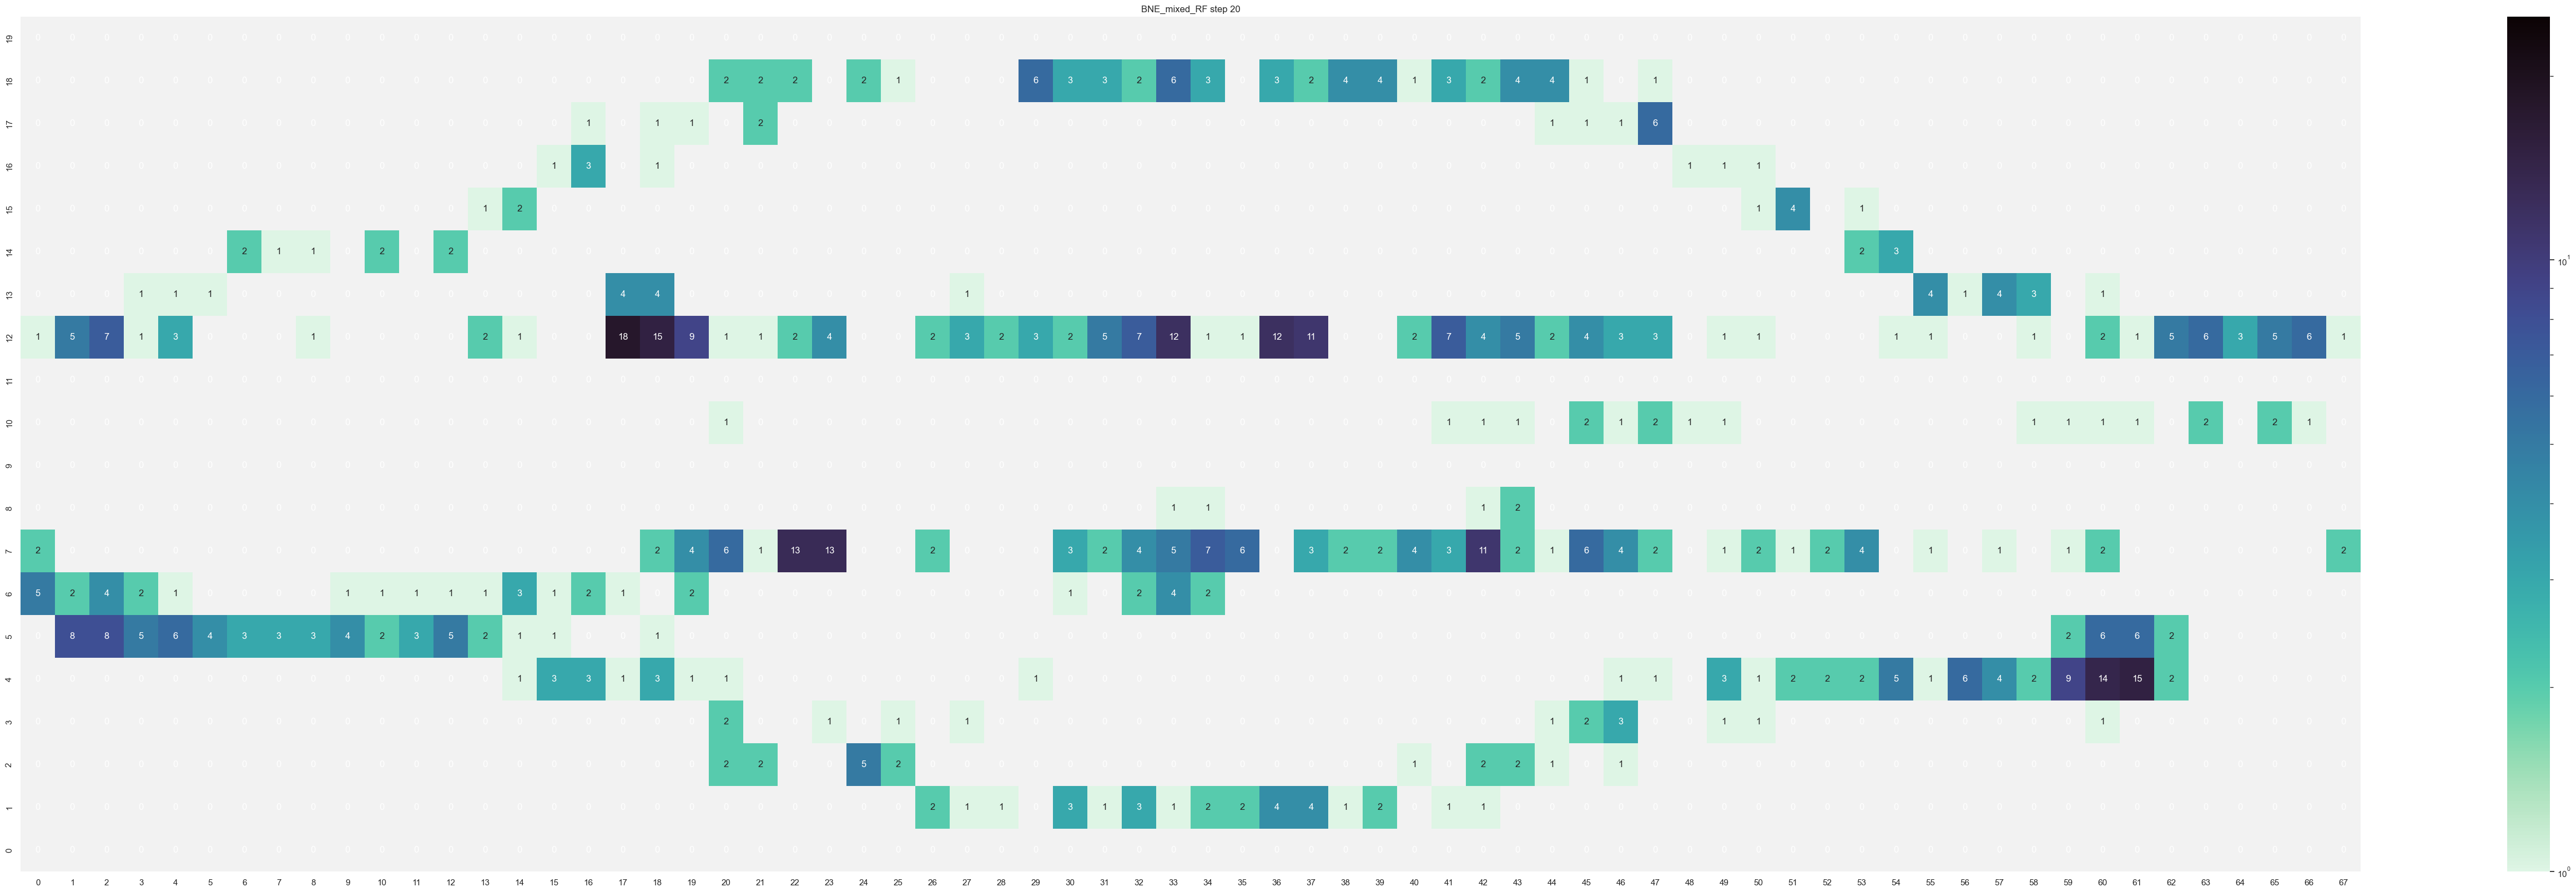

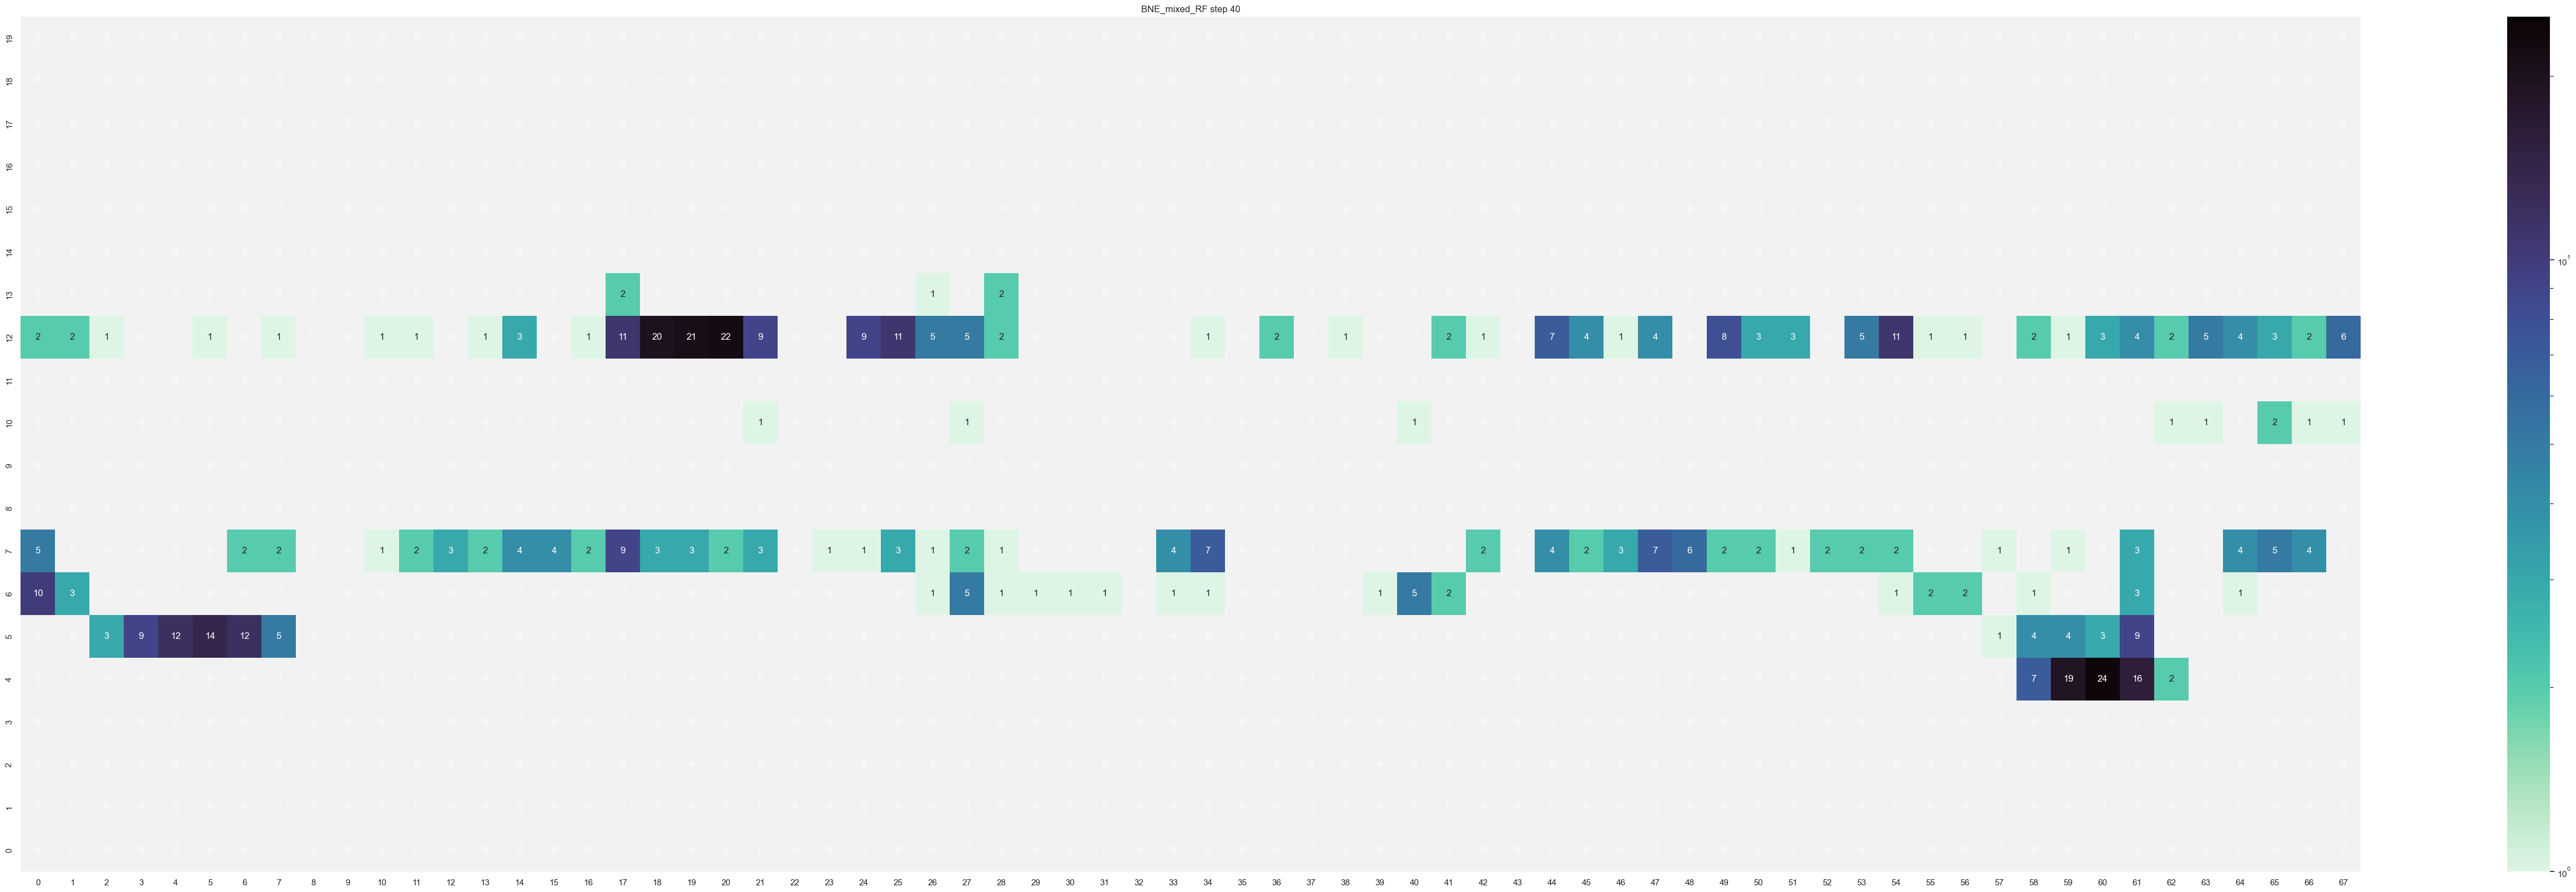

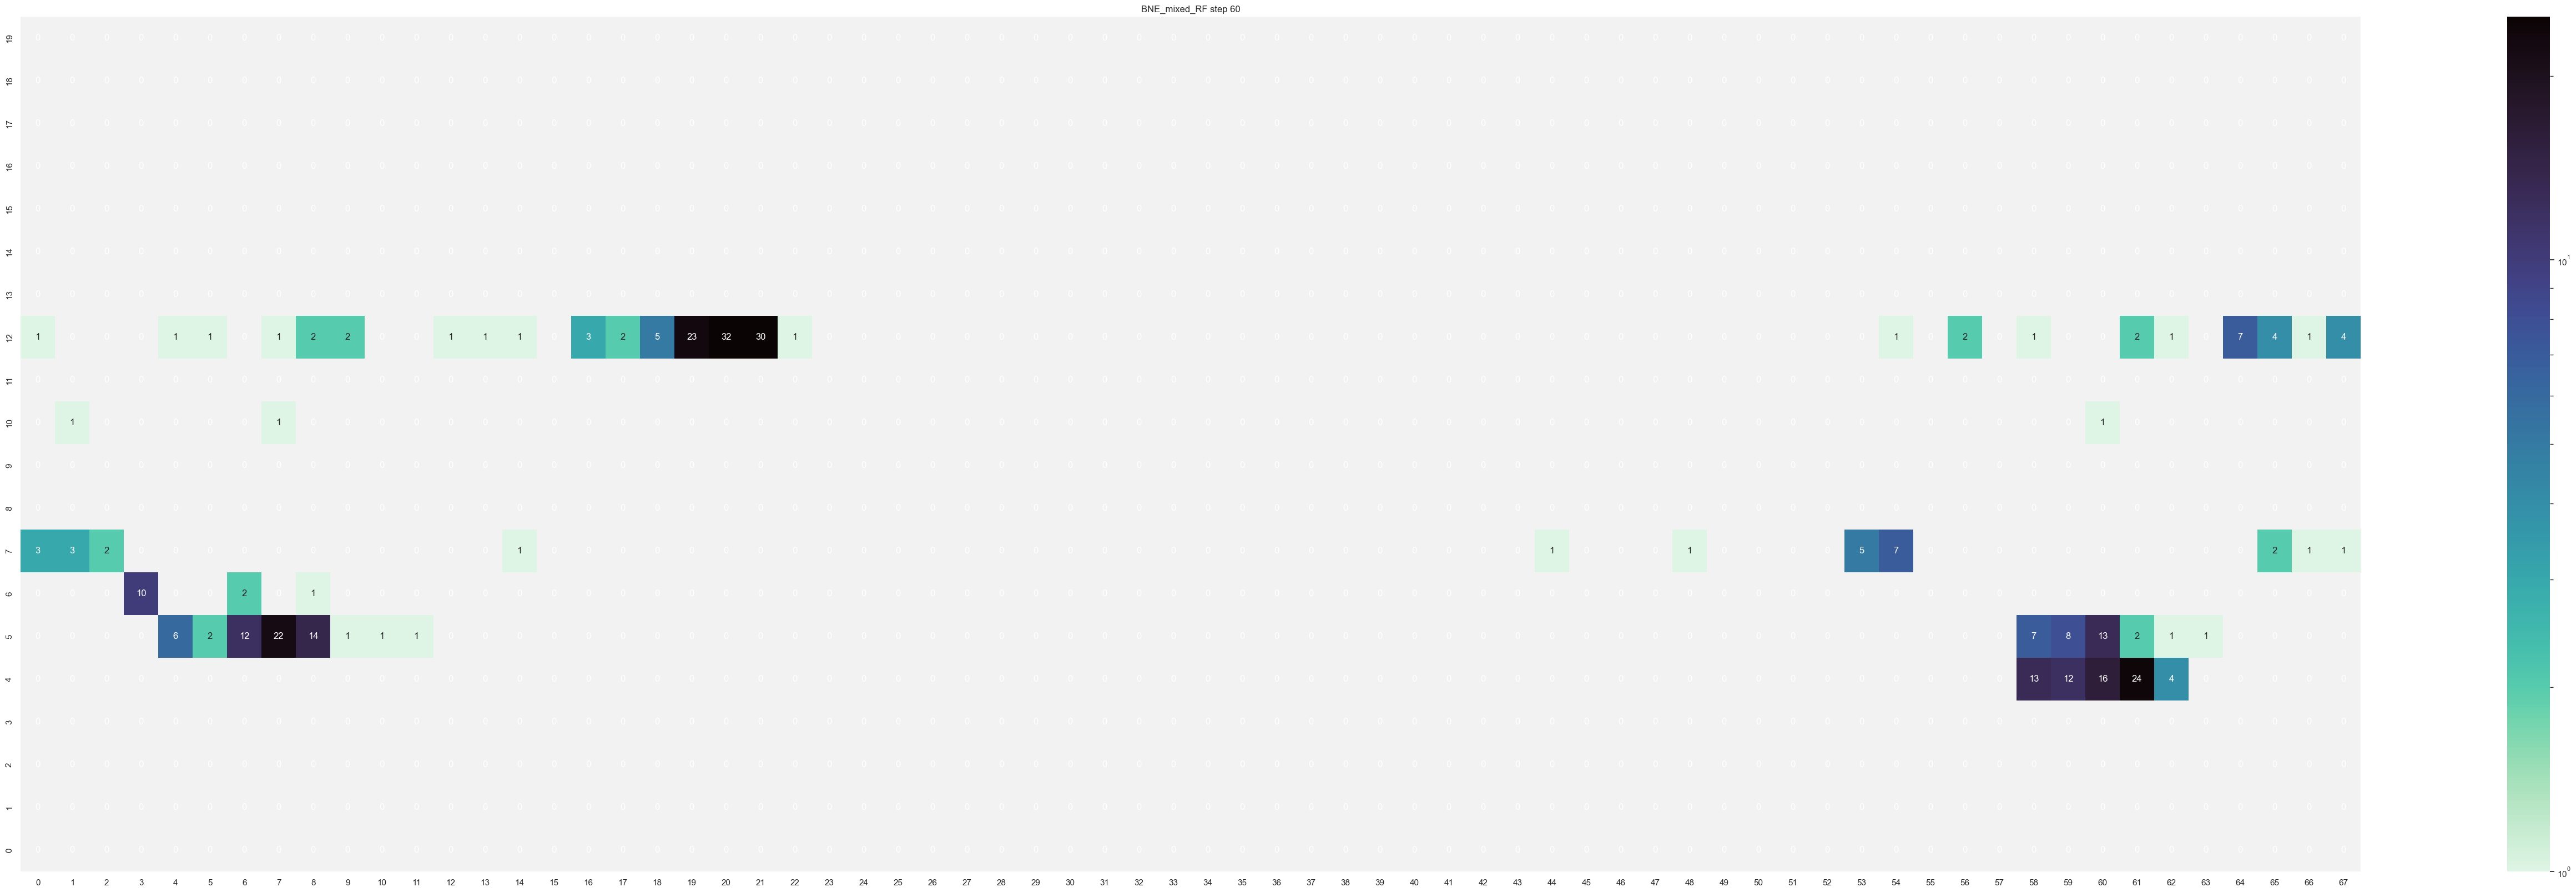

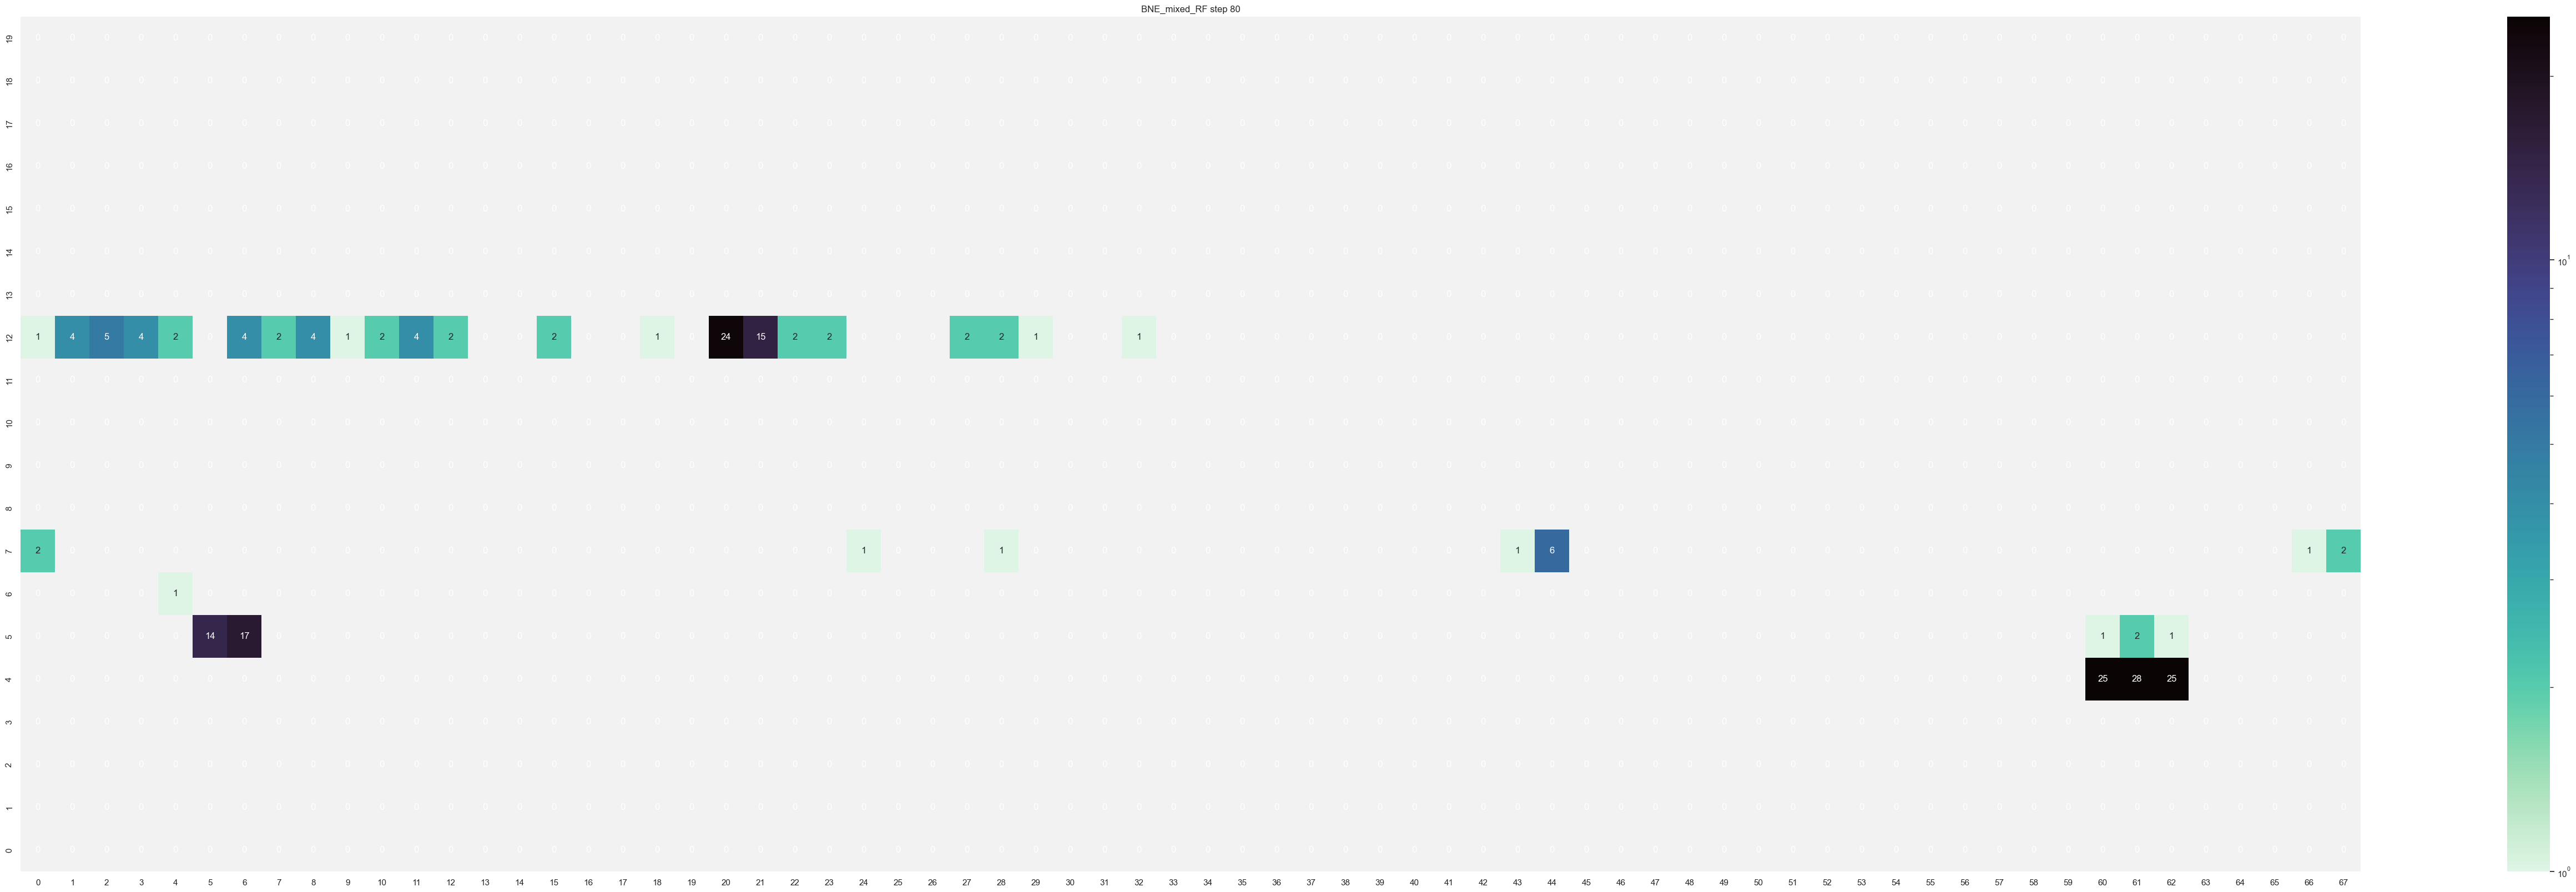

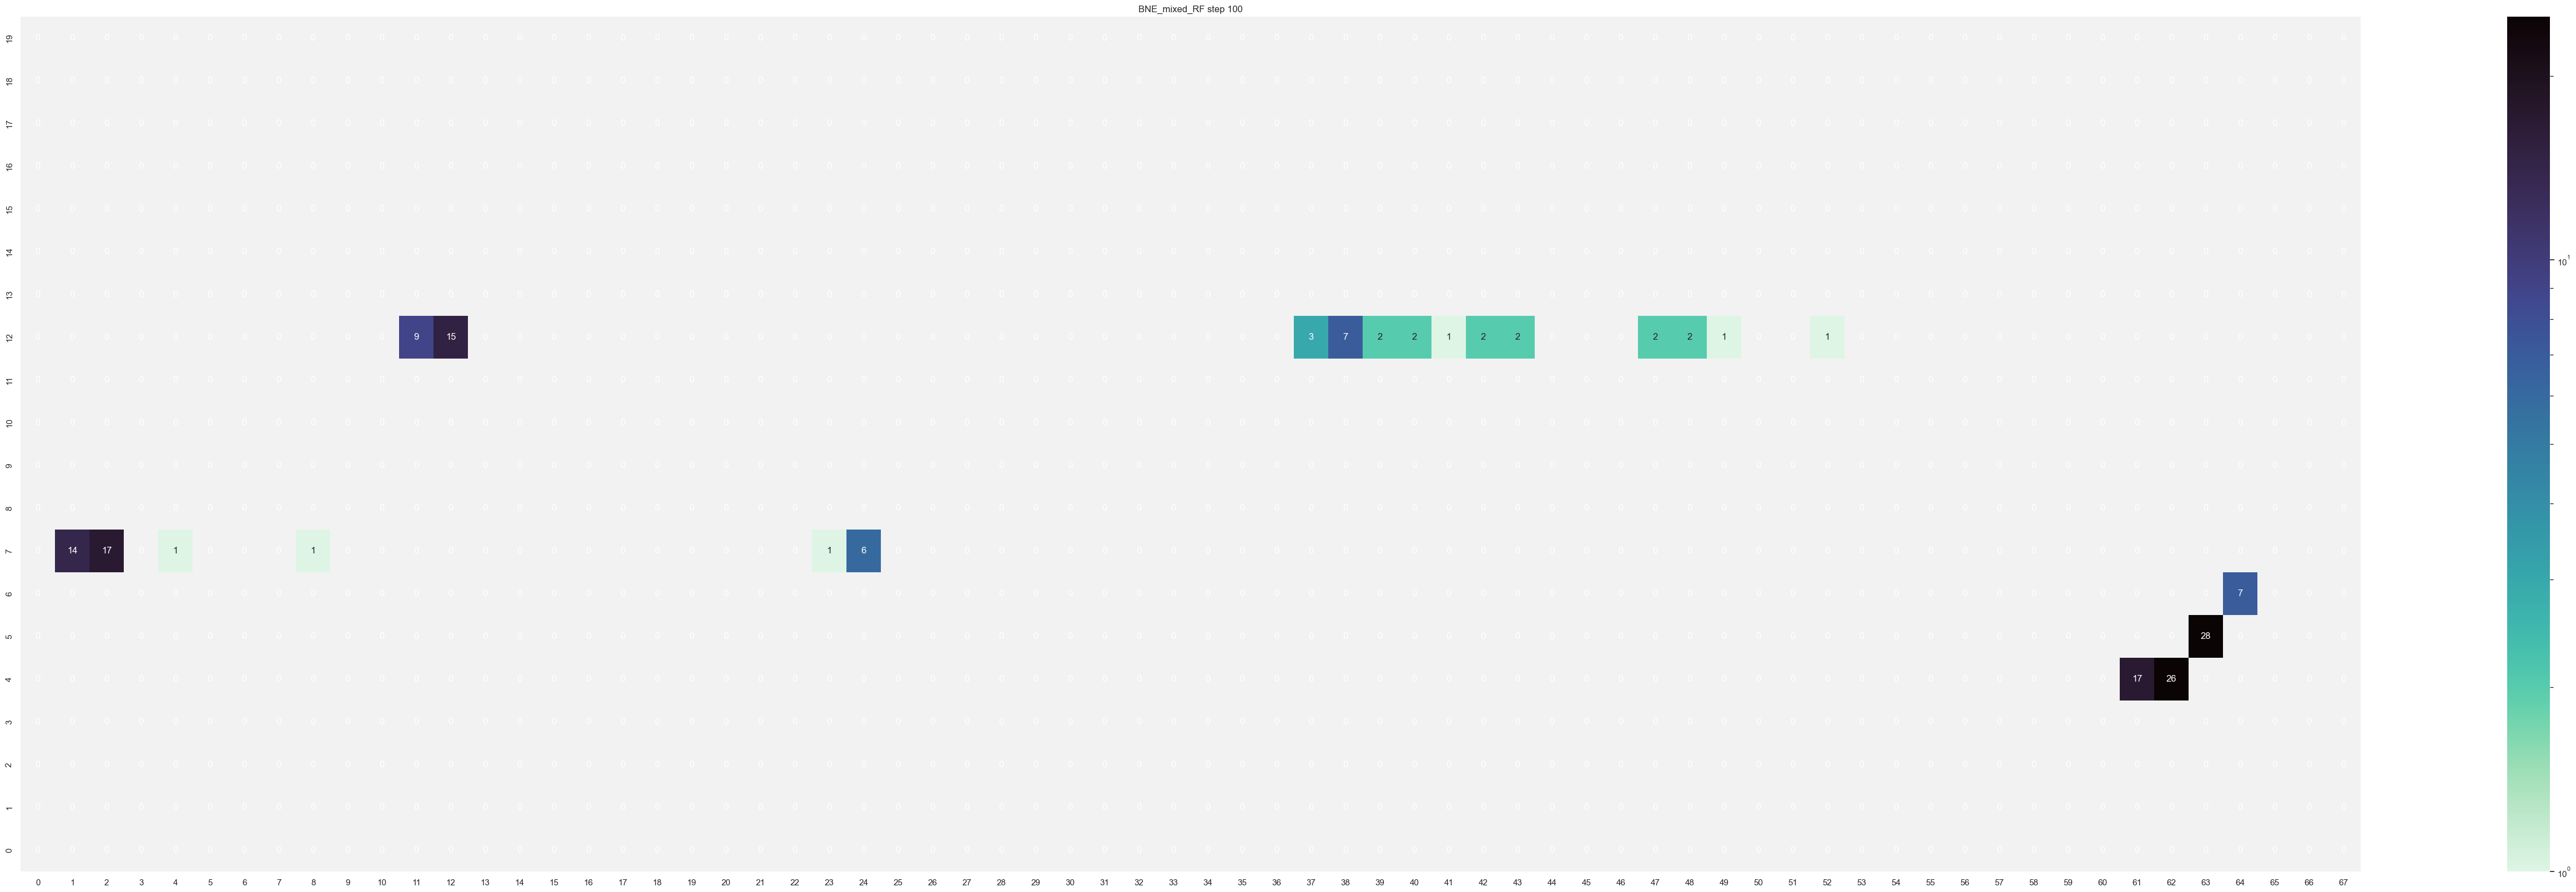

In [12]:
frames(("BNE_mixed_RF", 0))

### Czas ewakuacji w zależności od liczby agentów dla wszystkich metod

In [ ]:
Ns = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
iters = 50

def simulate_for_N(Ns, model_type, iters = iters):
    all_results = np.zeros(iters*len(Ns))
    for i, N in enumerate(Ns):
        results = batch_run({"n": N , "width": 68, "height": 20, "door_width": 6, "seed": None, "model_type": model_type[0], "p_BNE": model_type[1]}, iters = iters)
        all_results[i*iters:(i+1)*iters] += results.values

    return all_results

In [19]:
Ns_BNE = simulate_for_N(Ns, ("BNE_mixed_SR", 100))

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
Ns_SR = simulate_for_N(Ns, ("BNE_mixed_SR", 0))

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [21]:
Ns_RF = simulate_for_N(Ns, ("BNE_mixed_RF", 0))

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [26]:
Ns_df = pd.DataFrame(
    {   "model_type": np.repeat(["BNE", "RF", "SR"], iters*len(Ns)),
        "n": np.tile(np.repeat(Ns, iters),3),
        "exit_time": np.concatenate((Ns_BNE, Ns_RF, Ns_SR))
    })
Ns_df

,model_type,n,exit_time
0,BNE,100,68.0
1,BNE,100,67.0
2,BNE,100,67.0
3,BNE,100,68.0
4,BNE,100,68.0
...,...,...,...
1345,SR,1000,239.0
1346,SR,1000,235.0
1347,SR,1000,254.0
1348,SR,1000,230.0


Text(0.5, 0, 'n (liczba agentów)')

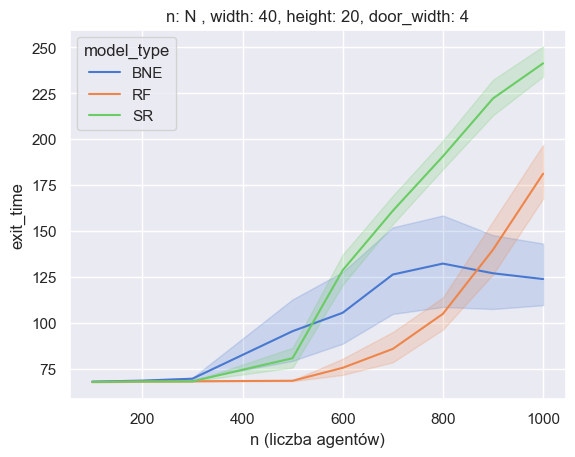

In [27]:
sns.set_theme()
sns.lineplot(data = Ns_df, x = "n", y="exit_time", hue = "model_type", palette="muted" )
plt.title("n: N , width: 40, height: 20, door_width: 4")
plt.xlabel("n (liczba agentów)")

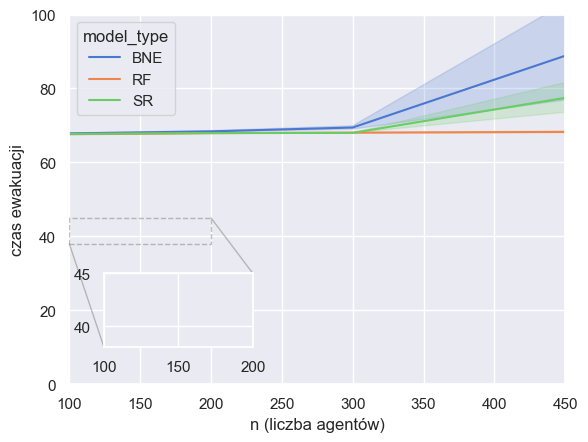

In [24]:
fig, ax = plt.subplots()
sns.lineplot(data = Ns_df, x = "n", y="exit_time", hue = "model_type", palette="muted",ax=ax)
plt.xlabel("n (liczba agentów)")
plt.ylabel("czas ewakuacji")
plt.xlim(100,450)
plt.ylim(0,100)


zm = ax.inset_axes([0.07, 0.1, 0.3, 0.2], xlim = (100,200), ylim = (38, 45))
sns.lineplot(data=Ns_df, x='n', y='exit_time', hue= "model_type", ax =zm, legend=False)
ax.indicate_inset_zoom(zm, edgecolor = 'gray', linestyle = '--', alpha = 0.5)
zm.set(xlabel=None)
zm.set(ylabel=None)
plt.show()